In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import matplotlib.pyplot as plt
import math
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import LSTM, Dense

In [2]:
def plot_seasonal_comparison(test_index, ys_test_rescaled, predictions_rescaled):
    """
    Plot the average actual and forecasted load for each season.

    Parameters:
    - test_index: Datetime index for the test data.
    - ys_test_rescaled: Rescaled actual test values.
    - predictions_rescaled: Rescaled forecasted values.
    """
    # Create a DataFrame to hold the test and prediction data
    data = pd.DataFrame({
        'Actual': ys_test_rescaled.flatten(),
        'Predicted': predictions_rescaled.flatten()
    }, index=test_index)
    
    # Add a 'Season' column to the DataFrame
    data['Month'] = data.index.month
    data['Season'] = data['Month'].apply(lambda x: (
        'Winter' if x in [12, 1, 2] else
        'Spring' if x in [3, 4, 5] else
        'Summer' if x in [6, 7, 8] else
        'Autumn'
    ))
    
    # Group by season and calculate the mean for actual and predicted values
    seasonal_data = data.groupby('Season').mean()
    
    # Plot the seasonal comparison
    plt.figure(figsize=(12, 6))
    plt.plot(seasonal_data.index, seasonal_data['Actual'], label='Actual Load', marker='o')
    plt.plot(seasonal_data.index, seasonal_data['Predicted'], label='Forecasted Load', marker='o')
    plt.xlabel('Season')
    plt.ylabel('Average Load')
    plt.title('Average Actual Load and Forecasted Load by Season')
    plt.legend()
    plt.grid(True)
    plt.show()

In [3]:
def plot_monthly_comparison(test_index, ys_test_rescaled, predictions_rescaled):
    """
    Plot the average actual and forecasted load by month.

    Parameters:
    - test_index: Datetime index for the test data.
    - ys_test_rescaled: Rescaled actual test values.
    - predictions_rescaled: Rescaled forecasted values.
    """
    # Create a DataFrame to hold the test and prediction data
    data = pd.DataFrame({
        'Actual': ys_test_rescaled.flatten(),
        'Predicted': predictions_rescaled.flatten()
    }, index=test_index)
    
    # Add a 'Month' column to the DataFrame
    data['Month'] = data.index.month

    # Group by month and calculate the mean for actual and predicted values
    monthly_data = data.groupby('Month').mean()

    # Create month labels corresponding to the months present in the dataset
    month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    available_months = monthly_data.index
    available_labels = [month_labels[month - 1] for month in available_months]

    # Plot the monthly comparison
    plt.figure(figsize=(12, 6))
    plt.plot(monthly_data.index, monthly_data['Actual'], label='Actual Load', marker='o')
    plt.plot(monthly_data.index, monthly_data['Predicted'], label='Forecasted Load', marker='o')
    plt.xlabel('Month')
    plt.ylabel('Average Load')
    plt.title('Average Actual Load and Forecasted Load by Month')
    plt.xticks(ticks=monthly_data.index, labels=available_labels)
    plt.legend()
    plt.grid(True)
    plt.show()

In [4]:
def plot_weekday_comparison(test_index, ys_test_rescaled, predictions_rescaled):
    """
    Plot the average actual and forecasted load by day of the week.

    Parameters:
    - test_index: Datetime index for the test data.
    - ys_test_rescaled: Rescaled actual test values.
    - predictions_rescaled: Rescaled forecasted values.
    """
    # Create a DataFrame to hold the test and prediction data
    data = pd.DataFrame({
        'Actual': ys_test_rescaled.flatten(),
        'Predicted': predictions_rescaled.flatten()
    }, index=test_index)
    
    # Add a 'DayOfWeek' column to the DataFrame
    data['DayOfWeek'] = data.index.dayofweek

    # Group by day of the week and calculate the mean for actual and predicted values
    weekday_data = data.groupby('DayOfWeek').mean()

    # Create day labels corresponding to the days of the week
    day_labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    available_days = weekday_data.index
    available_day_labels = [day_labels[day] for day in available_days]

    # Plot the weekday comparison
    plt.figure(figsize=(12, 6))
    plt.plot(weekday_data.index, weekday_data['Actual'], label='Actual Load', marker='o')
    plt.plot(weekday_data.index, weekday_data['Predicted'], label='Forecasted Load', marker='o')
    plt.xlabel('Day of the Week')
    plt.ylabel('Average Load')
    plt.title('Average Actual Load and Forecasted Load by Day of the Week')
    plt.xticks(ticks=weekday_data.index, labels=available_day_labels)
    plt.legend()
    plt.grid(True)
    plt.show()


In [5]:
def plot_hourly_comparison(test_index, ys_test_rescaled, predictions_rescaled):
    """
    Plot the average actual and forecasted load by hour of the day.

    Parameters:
    - test_index: Datetime index for the test data.
    - ys_test_rescaled: Rescaled actual test values.
    - predictions_rescaled: Rescaled forecasted values.
    """
    # Create a DataFrame to hold the test and prediction data
    data = pd.DataFrame({
        'Actual': ys_test_rescaled.flatten(),
        'Predicted': predictions_rescaled.flatten()
    }, index=test_index)
    
    # Add an 'Hour' column to the DataFrame
    data['Hour'] = data.index.hour

    # Group by hour of the day and calculate the mean for actual and predicted values
    hourly_data = data.groupby('Hour').mean()

    # Create hour labels corresponding to the hours of the day
    available_hours = hourly_data.index
    available_hour_labels = [f'{hour}:00' for hour in available_hours]

    # Plot the hourly comparison
    plt.figure(figsize=(12, 6))
    plt.plot(hourly_data.index, hourly_data['Actual'], label='Actual Load', marker='o')
    plt.plot(hourly_data.index, hourly_data['Predicted'], label='Forecasted Load', marker='o')
    plt.xlabel('Hour of the Day')
    plt.ylabel('Average Load')
    plt.title('Average Actual Load and Forecasted Load by Hour of the Day')
    plt.xticks(ticks=hourly_data.index, labels=available_hour_labels)
    plt.legend()
    plt.grid(True)
    plt.show()

In [6]:
def plot_results_from_to(test_index, ys_test_rescaled, predictions_rescaled, start_date, end_date):
    """
    Plot the actual and forecasted load for a specified date range.

    Parameters:
    - test_index: Datetime index for the test data.
    - ys_test_rescaled: Rescaled actual test values.
    - predictions_rescaled: Rescaled forecasted values.
    - start_date: Start date for the plot.
    - end_date: End date for the plot.
    """
    # Convert start_date and end_date to datetime if they are strings
    if isinstance(start_date, str):
        start_date = pd.to_datetime(start_date)
    if isinstance(end_date, str):
        end_date = pd.to_datetime(end_date)

    # Create a boolean mask for the date range
    mask = (test_index >= start_date) & (test_index <= end_date)

    # Apply the mask to the test data and predictions
    time_index = test_index[mask]
    ys_test_range = ys_test_rescaled[mask]
    predictions_range = predictions_rescaled[mask]

    # Plotting the actual and forecasted load for the specified date range
    plt.figure(figsize=(24, 5))
    plt.plot(time_index, ys_test_range.flatten(), label='Actual Load')
    plt.plot(time_index, predictions_range.flatten(), label='Forecasted Load')
    plt.xlabel('Time')
    plt.ylabel('Load')
    plt.title(f'Actual Load and Forecasted Load from {start_date:%Y-%m-%d} to {end_date:%Y-%m-%d}')
    plt.legend()

    # Customize x-axis to show date and day of the week
    plt.xticks(ticks=time_index[::24], labels=[f"{date:%Y-%m-%d}\n{date:%A}" for date in time_index[::24]], rotation=45)
    plt.show()


In [7]:

def plot_results(test_index, ys_test_rescaled, predictions_rescaled, hours_to_plot=720):
    """
    Plot the actual and forecasted load for the first month.

    Parameters:
    - test_index: Datetime index for the test data.
    - ys_test_rescaled: Rescaled actual test values.
    - predictions_rescaled: Rescaled forecasted values.
    - hours_in_month: Number of hours to plot for the first month.
    """
    # Adjust the test index to include only the first month of data
    time_index = test_index[:hours_to_plot]
    ys_test_first_month = ys_test_rescaled[:hours_to_plot]
    predictions_first_month = predictions_rescaled[:hours_to_plot]

    # Plotting the initial month of actual and forecasted load
    plt.figure(figsize=(24, 5))
    plt.plot(time_index, ys_test_first_month.flatten(), label='Actual Load')
    plt.plot(time_index, predictions_first_month.flatten(), label='Forecasted Load')
    plt.xlabel('Time')
    plt.ylabel('Load')
    plt.title('Actual Load and Forecasted Load for the First Month')
    plt.legend()

    # Customize x-axis to show date and day of the week
    plt.xticks(ticks=time_index[::24], labels=[f"{date:%Y-%m-%d}\n{date:%A}" for date in time_index[::24]], rotation=45)
    plt.show()


In [8]:
def build_and_train_model(xs_train, ys_train, model_config, num_target_features,path_to_save_model):
    """
    Build, train, and evaluate an LSTM model.

    Parameters:
    - xs_train, ys_train: Training data.
    - xs_test, ys_test: Test data.
    - model_config: Dictionary containing LSTM layers configuration and other model parameters.
    - scaler: Scaler used to scale data.
    - num_target_features: Number of output features for the model.

    Returns:
    - model: Trained LSTM model.
    - history: Training history of the model.
    - predictions_rescaled: Rescaled predictions.
    - ys_test_rescaled: Rescaled actual values.
    """
    # Build the LSTM model
    model = Sequential()
    input_shape = (xs_train.shape[1], xs_train.shape[2])

    for layer_config in model_config['lstm_layers']:
        model.add(LSTM(layer_config['units'], return_sequences=layer_config['return_sequences'], input_shape=input_shape if 'input_shape' not in layer_config else None))
        input_shape = None  # For subsequent layers, input_shape is not required

    model.add(Dense(num_target_features))
    model.compile(optimizer='adam', loss='mse')

    # Train the model
    # Define the early stopping and model checkpoint callbacks
    early_stopping = EarlyStopping(monitor='loss', patience=10, verbose=1, restore_best_weights=True)
    checkpoint = ModelCheckpoint(path_to_save_model, monitor='loss', verbose=1, save_best_only=True, mode='min')

    history = model.fit(xs_train, ys_train, epochs=model_config.get('epochs', 50), batch_size=model_config.get('batch_size', 32), callbacks=[early_stopping, checkpoint])

    return model, history


In [9]:
def create_sequences(data, seq_length, forecast_horizon, target_col):
    target_col_index = target_col
    xs, ys = [], []
    target_col_name = data.columns[target_col_index]  
    for i in range(len(data) - seq_length - forecast_horizon + 1):
        x = data.iloc[i:(i + seq_length)].values
      #  x = data.iloc[i:(i + seq_length)].drop(columns=[target_col_name]).values 
        y = data.iloc[(i + seq_length):(i + seq_length + forecast_horizon), target_col].values
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [10]:
# Load and preprocess data
#data_df = pd.read_csv('../../data/processed/actuals_data.csv', parse_dates=['Time'], index_col='Time')
# Dataset with actual weather variables
# data_df = pd.read_csv('../data/interim/precovid-data/train/load_with_actual_weather_variables_dataset.csv', parse_dates=['Time'], index_col='Time')

# Dataset with forecasted weather variables
data_df = pd.read_csv('../data/interim/precovid-data/train/load_with_forecasted_weather_variables_dataset.csv', parse_dates=['Time'], index_col='Time')
coloumns_to_drop  = ['Pressure_kpa','Cloud Cover (%)','Wind Direction (deg)','Wind Speed (kmh)']
data_df = data_df.drop(columns=coloumns_to_drop)

#data preprocessing
hour_of_day_col = data_df.index.hour
data_df['hour_of_day_sin'] = np.sin(2 * np.pi * hour_of_day_col / 24)
data_df['hour_of_day_cos'] = np.cos(2 * np.pi * hour_of_day_col / 24)

load_col = data_df.pop('Load (kW)')
data_df['Load (kW)'] = load_col

target_col = (data_df.columns.get_loc('Load (kW)'))
num_target_features = 1
scaler_num_features = data_df.shape[1]

In [11]:
data_df

,Temperature (C),hour_of_day_sin,hour_of_day_cos,Load (kW)
Time,,,,
2017-03-18 00:00:00,14,0.000000,1.000000e+00,1.031472e+06
2017-03-18 01:00:00,14,0.258819,9.659258e-01,1.007206e+06
2017-03-18 02:00:00,14,0.500000,8.660254e-01,9.861084e+05
2017-03-18 03:00:00,14,0.707107,7.071068e-01,9.707610e+05
2017-03-18 04:00:00,14,0.866025,5.000000e-01,9.622584e+05
...,...,...,...,...
2020-01-17 04:00:00,8,0.866025,5.000000e-01,9.767850e+05
2020-01-17 05:00:00,6,0.965926,2.588190e-01,9.912850e+05
2020-01-17 06:00:00,6,1.000000,6.123234e-17,1.025285e+06


In [12]:
#1. Scale data
scaler = MinMaxScaler()
data_df_scaled = pd.DataFrame(scaler.fit_transform(data_df), columns=data_df.columns, index=data_df.index)

In [13]:
scaler.feature_names_in_

array(['Temperature (C)', 'hour_of_day_sin', 'hour_of_day_cos',
       'Load (kW)'], dtype=object)

In [14]:

#2. Create sequences pairs of input and output
#In this case we have to configure the target_col-1 to be the index of the target column in the data_df in order to assign in the ys variable
# and have input output pairs of sequences
seq_length = 2
forecast_horizon = 1
xs, ys = create_sequences(data_df_scaled, seq_length, forecast_horizon, target_col)
print(xs.shape, ys.shape)

(24847, 2, 4) (24847, 1)


In [15]:
data_df_scaled

,Temperature (C),hour_of_day_sin,hour_of_day_cos,Load (kW)
Time,,,,
2017-03-18 00:00:00,0.729730,0.500000,1.000000,0.244827
2017-03-18 01:00:00,0.729730,0.629410,0.982963,0.212886
2017-03-18 02:00:00,0.729730,0.750000,0.933013,0.185117
2017-03-18 03:00:00,0.729730,0.853553,0.853553,0.164915
2017-03-18 04:00:00,0.729730,0.933013,0.750000,0.153724
...,...,...,...,...
2020-01-17 04:00:00,0.648649,0.933013,0.750000,0.172845
2020-01-17 05:00:00,0.621622,0.982963,0.629410,0.191931
2020-01-17 06:00:00,0.621622,1.000000,0.500000,0.236684


In [16]:
xs[0]

array([[0.72972973, 0.5       , 1.        , 0.24482718],
       [0.72972973, 0.62940952, 0.98296291, 0.21288642]])

In [17]:
ys[0]

array([0.18511677])

In [18]:
#3. Split data
train_size = 0.7
num_samples = len(xs)
train_end = int(num_samples * train_size)

xs_train = xs[:train_end]
ys_train = ys[:train_end]
xs_test = xs[train_end:]
ys_test = ys[train_end:]

In [19]:
data_df_scaled

,Temperature (C),hour_of_day_sin,hour_of_day_cos,Load (kW)
Time,,,,
2017-03-18 00:00:00,0.729730,0.500000,1.000000,0.244827
2017-03-18 01:00:00,0.729730,0.629410,0.982963,0.212886
2017-03-18 02:00:00,0.729730,0.750000,0.933013,0.185117
2017-03-18 03:00:00,0.729730,0.853553,0.853553,0.164915
2017-03-18 04:00:00,0.729730,0.933013,0.750000,0.153724
...,...,...,...,...
2020-01-17 04:00:00,0.648649,0.933013,0.750000,0.172845
2020-01-17 05:00:00,0.621622,0.982963,0.629410,0.191931
2020-01-17 06:00:00,0.621622,1.000000,0.500000,0.236684


In [20]:
xs_train

array([[[0.72972973, 0.5       , 1.        , 0.24482718],
        [0.72972973, 0.62940952, 0.98296291, 0.21288642]],

       [[0.72972973, 0.62940952, 0.98296291, 0.21288642],
        [0.72972973, 0.75      , 0.9330127 , 0.18511677]],

       [[0.72972973, 0.75      , 0.9330127 , 0.18511677],
        [0.72972973, 0.85355339, 0.85355339, 0.16491536]],

       ...,

       [[0.94594595, 0.37059048, 0.01703709, 0.89367133],
        [0.91891892, 0.25      , 0.0669873 , 0.90303254]],

       [[0.91891892, 0.25      , 0.0669873 , 0.90303254],
        [0.91891892, 0.14644661, 0.14644661, 0.90117421]],

       [[0.91891892, 0.14644661, 0.14644661, 0.90117421],
        [0.91891892, 0.0669873 , 0.25      , 0.89091199]]])

In [21]:
ys_train

array([[0.18511677],
       [0.16491536],
       [0.15372361],
       ...,
       [0.90117421],
       [0.89091199],
       [0.8381034 ]])

In [22]:
#4. Define the model configuration
model_config = {
    'lstm_layers': [
        {'units': 64, 'return_sequences': True},
        {'units': 32, 'return_sequences': True},
        {'units': 16, 'return_sequences': False}
    ],
    'epochs': 300,
    'batch_size': 32
}

In [23]:
#5. Build, train, and evaluate the model
multivariate_load_foreacasting_load_temp_included_model_path = '../models/multivariate_load_foreacasting_load_temp_included_model.keras'
num_target_features = 1 # The number of output features for the model only load for now
model, history = build_and_train_model(
    xs_train, ys_train, model_config, num_target_features, path_to_save_model = multivariate_load_foreacasting_load_temp_included_model_path
)

Epoch 1/300


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


513/544 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step - loss: 0.0337
Epoch 1: loss improved from inf to 0.00987, saving model to ../../models/multivariate_load_foreacasting_load_temp_included_model.keras
544/544 ━━━━━━━━━━━━━━━━━━━━ 1s 960us/step - loss: 0.0323
Epoch 2/300
493/544 ━━━━━━━━━━━━━━━━━━━━ 0s 922us/step - loss: 0.0018
Epoch 2: loss improved from 0.00987 to 0.00166, saving model to ../../models/multivariate_load_foreacasting_load_temp_included_model.keras
544/544 ━━━━━━━━━━━━━━━━━━━━ 1s 977us/step - loss: 0.0018
Epoch 3/300
528/544 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0014
Epoch 3: loss improved from 0.00166 to 0.00125, saving model to ../../models/multivariate_load_foreacasting_load_temp_included_model.keras
544/544 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0014
Epoch 4/300
537/544 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.3193e-04
Epoch 4: loss improved from 0.00125 to 0.00058, saving model to ../../models/multivariate_load_foreacasting_load_temp_included_model.keras
544/544 

In [24]:
loss = model.evaluate(xs_test, ys_test)
print(f'Test Loss: {loss}')

233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step - loss: 1.5264e-04
Test Loss: 0.00016366908675991


In [25]:
xs_test.shape

(7455, 2, 4)

In [26]:
#5. Build, train, and evaluate the model

# Make predictions on the test set
predictions_scaled = model.predict(xs_test) # contains only load
predictions_scaled

233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step


array([[0.75137377],
       [0.66988075],
       [0.6097919 ],
       ...,
       [0.2142246 ],
       [0.31438285],
       [0.4223353 ]], dtype=float32)

In [27]:
predictions_scaled

array([[0.75137377],
       [0.66988075],
       [0.6097919 ],
       ...,
       [0.2142246 ],
       [0.31438285],
       [0.4223353 ]], dtype=float32)

In [28]:
# Rescale the predictions and actual values
# predictions=> contains values for target column (Load)
# but our scaler was trained on all columns so we have to inverse transform all columns
# so we need to padd with zeros the other columns
num_of_missing_training_features = data_df.shape[1] - num_target_features

padding_for_missing_training_features = np.zeros((predictions_scaled.shape[0], num_of_missing_training_features))
data_to_be_invert_from_scaling = np.hstack([padding_for_missing_training_features, predictions_scaled])
data_to_be_invert_from_scaling

array([[0.        , 0.        , 0.        , 0.75137377],
       [0.        , 0.        , 0.        , 0.66988075],
       [0.        , 0.        , 0.        , 0.60979187],
       ...,
       [0.        , 0.        , 0.        , 0.21422461],
       [0.        , 0.        , 0.        , 0.31438285],
       [0.        , 0.        , 0.        , 0.4223353 ]])

In [29]:
data_to_be_invert_from_scaling

array([[0.        , 0.        , 0.        , 0.75137377],
       [0.        , 0.        , 0.        , 0.66988075],
       [0.        , 0.        , 0.        , 0.60979187],
       ...,
       [0.        , 0.        , 0.        , 0.21422461],
       [0.        , 0.        , 0.        , 0.31438285],
       [0.        , 0.        , 0.        , 0.4223353 ]])

In [30]:
#Model outputs 
predictions= scaler.inverse_transform(data_to_be_invert_from_scaling)[:, target_col]
predictions

array([1416305.55174122, 1354393.61872028, 1308742.85903256, ...,
       1008222.22312286, 1084314.5131451 , 1166328.21917428])

In [31]:
ys_test

array([[0.75757359],
       [0.68379686],
       [0.61210283],
       ...,
       [0.23668395],
       [0.30578829],
       [0.40319251]])

In [32]:
xs_test.shape

(7455, 2, 4)

In [33]:
padding_for_missing_training_features = np.zeros((ys_test.shape[0], num_of_missing_training_features))
ys_test_scaled = np.hstack([padding_for_missing_training_features, ys_test])
ys_test_scaled
ys_test = scaler.inverse_transform(ys_test_scaled)[:,target_col]


In [34]:
ys_test.shape

(7455,)

In [35]:
ys_test

array([1421015.68673707, 1364965.97493707, 1310498.54233707, ...,
       1025285.04813707, 1077785.04813707, 1151785.04813707])

In [36]:
(abs(ys_test-predictions)).sum()

51365199.42730318

In [37]:
predictions

array([1416305.55174122, 1354393.61872028, 1308742.85903256, ...,
       1008222.22312286, 1084314.5131451 , 1166328.21917428])

In [38]:
predictions.shape

(7455,)

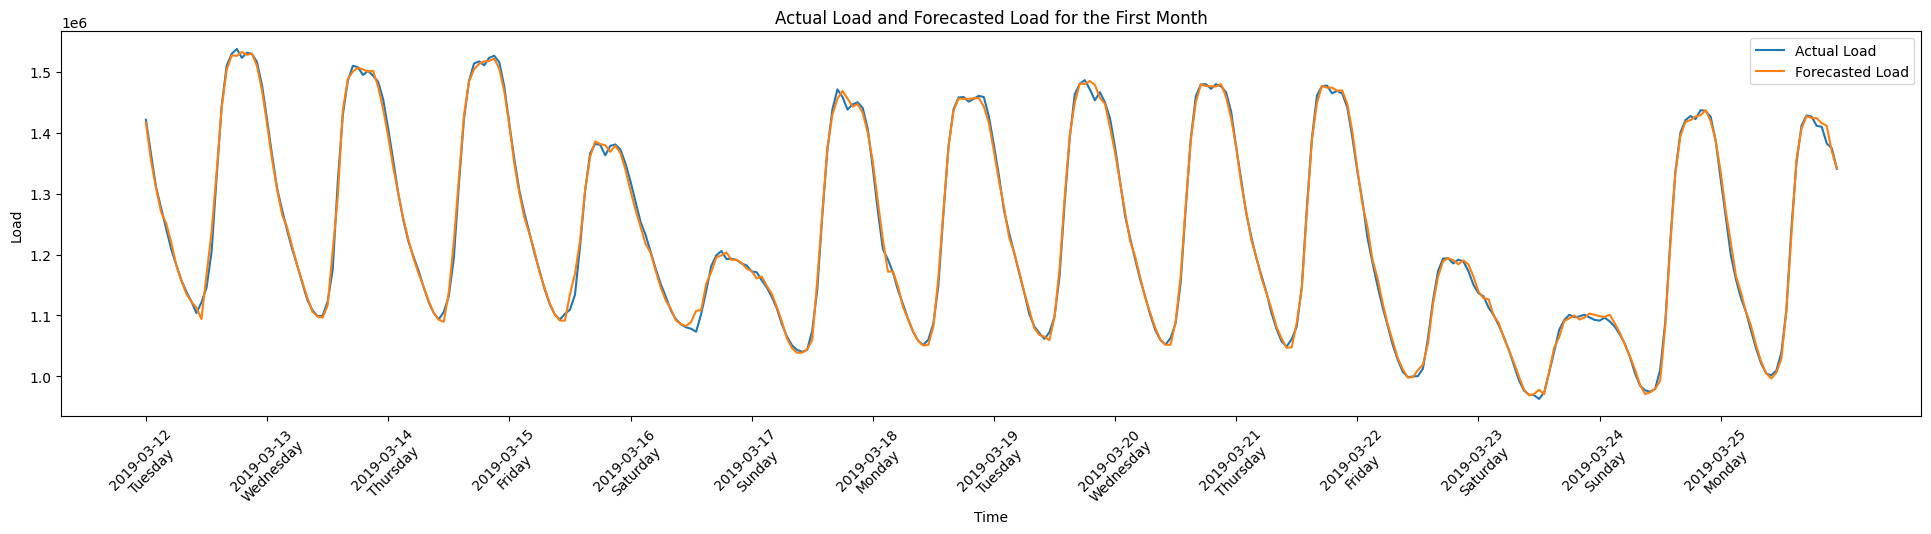

In [39]:
#6. Plot the results
test_index = data_df.index[-len(xs_test):]
hours_to_plot = 24*14 # Approximately one month

plot_results(test_index, ys_test, predictions, hours_to_plot=hours_to_plot)

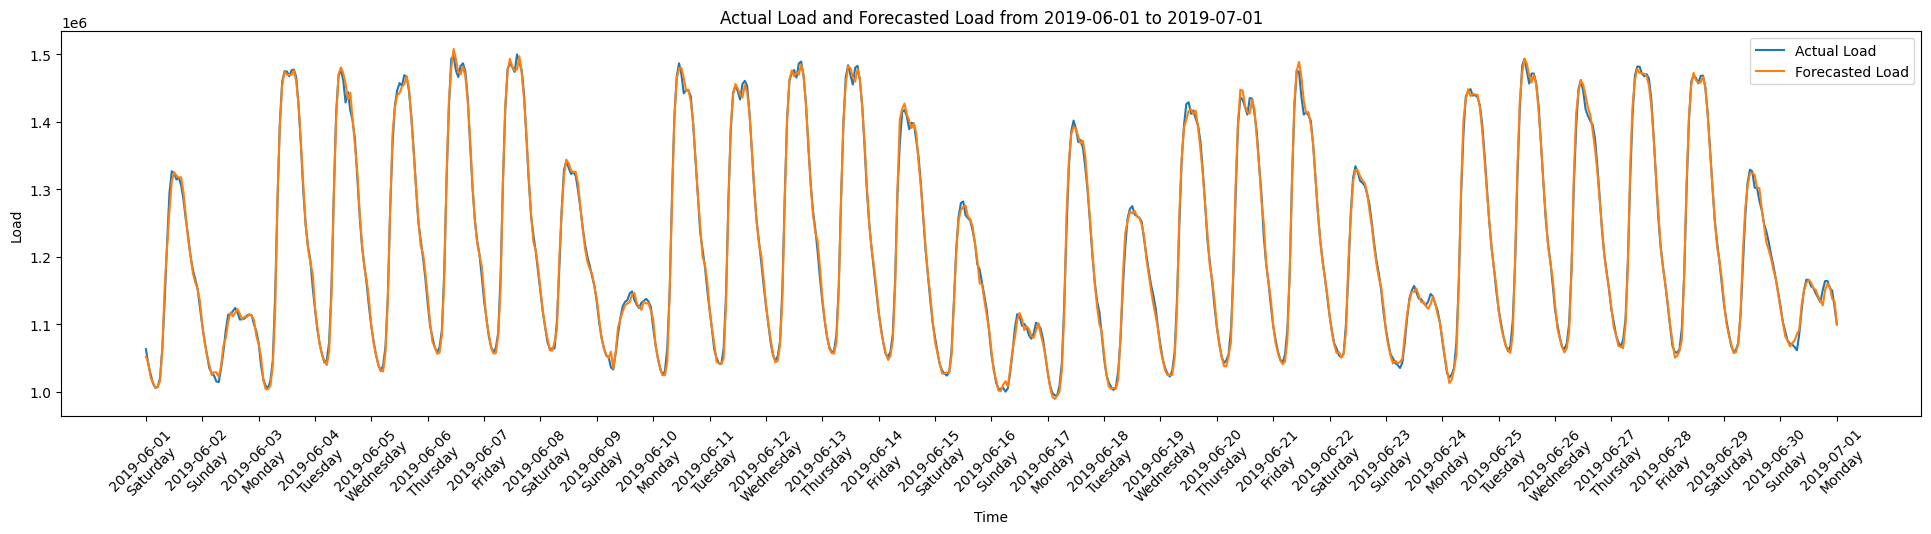

In [40]:
plot_results_from_to(test_index, ys_test, predictions,'2019-06-01', '2019-07-01')

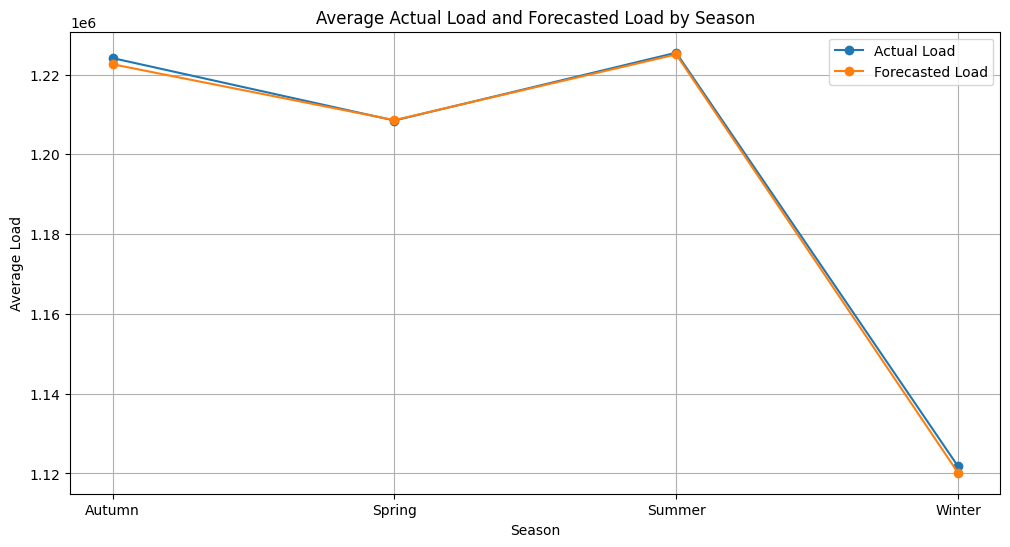

In [41]:
# Assuming you have your test_index, ys_test_rescaled, and predictions_rescaled already defined
plot_seasonal_comparison(test_index, ys_test, predictions)

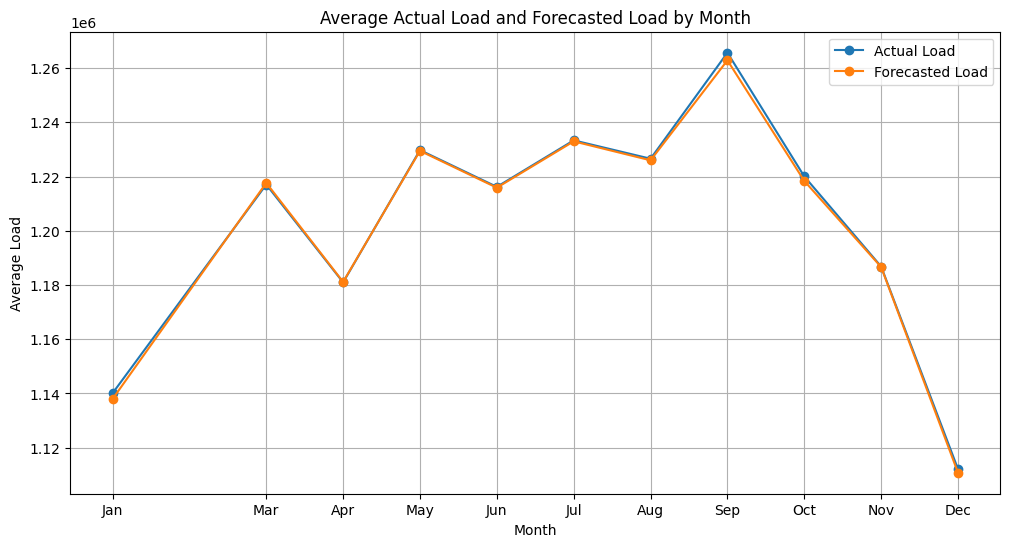

In [42]:
# Assuming you have your test_index, ys_test_rescaled, and predictions_rescaled already defined
plot_monthly_comparison(test_index, ys_test, predictions)

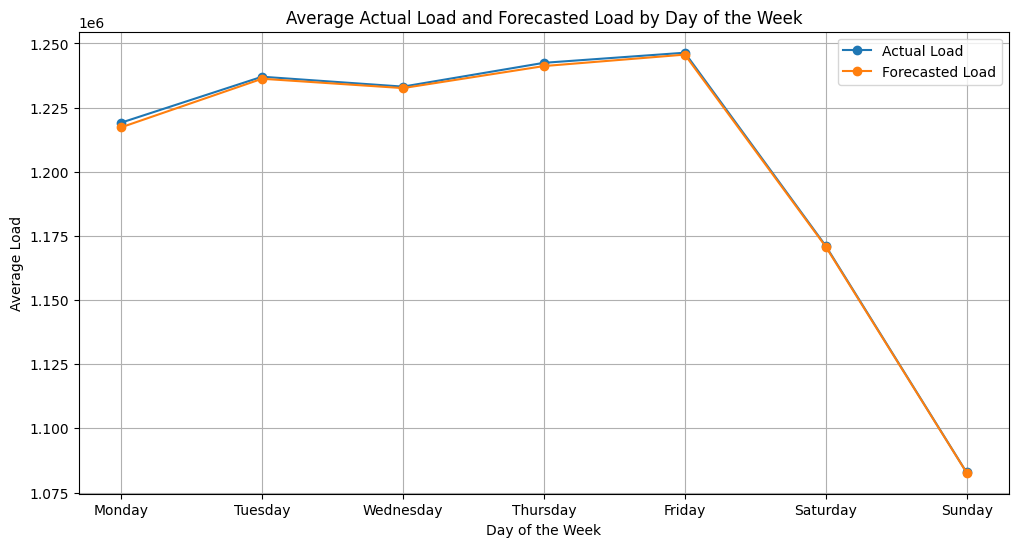

In [43]:
# Assuming you have your test_index, ys_test_rescaled, and predictions_rescaled already defined
plot_weekday_comparison(test_index, ys_test, predictions)

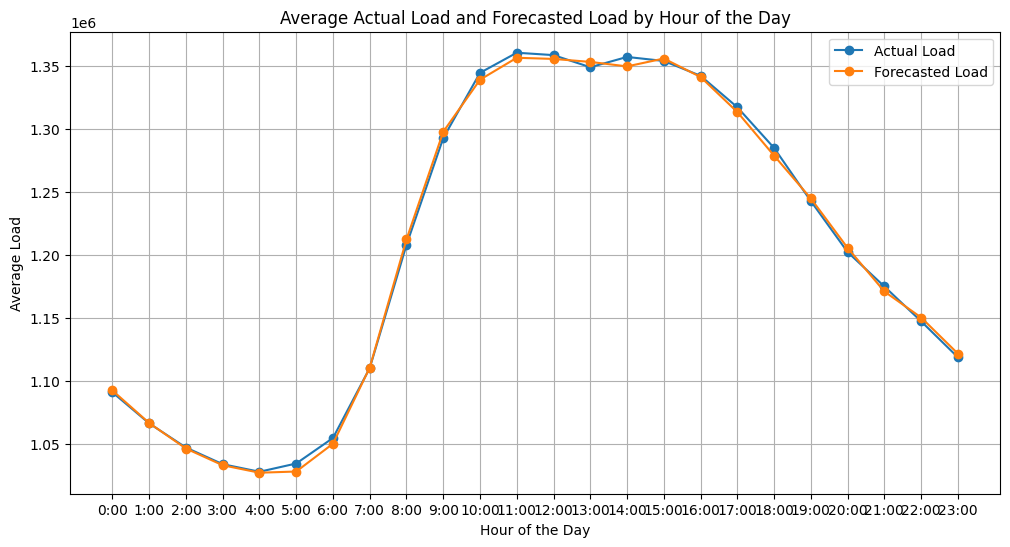

In [44]:
plot_hourly_comparison(test_index, ys_test, predictions)

In [45]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 2, 64)          │        17,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 90,341 (352.90 KB)

 Trainable params: 30,113 (117.63 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 60,228 (235.27 KB)

In [46]:
scaler.feature_names_in_

array(['Temperature (C)', 'hour_of_day_sin', 'hour_of_day_cos',
       'Load (kW)'], dtype=object)

In [47]:
def create_sequences_for_new_data(new_data_scaled, sequence_length):
    """
    Preprocess new data to create sequences and scale it.

    Parameters:
    - new_data: DataFrame containing new data.
    - sequence_length: Length of the input sequences for the LSTM.

    Returns:
    - X_new: Prepared sequences for model prediction.
    """

    # Create sequences
    sequences = []
    for i in range(len(new_data_scaled) - sequence_length + 1):
        sequences.append(new_data_scaled[i:i + sequence_length])
    
    return np.array(sequences)


In [48]:
# Load and preprocess data
new_data_df = pd.read_csv('../../data/interim/evaluation-period/actuals.csv', parse_dates=['Time'], index_col='Time')
new_data_df.dropna(inplace=True)


FileNotFoundError: [Errno 2] No such file or directory: '../../data/interim/evaluation-period/actuals.csv'

In [ ]:
# # Try to test them also in new data

# #We need to create sequences for the new data and scale them again because our models assumes sequences of scaled data
# # scaler assumes also target column is the last column in the data so we need zero padding

coloumns_to_drop = ["Pressure_kpa","Cloud Cover (%)","Wind Direction (deg)","Wind Speed (kmh)"]
new_data_df = new_data_df.drop(columns=coloumns_to_drop)
actual_load_col = new_data_df.pop('Load (kW)')

#Data preprocessing
hour_of_day_col = new_data_df.index.hour
new_data_df['hour_of_day_sin'] = np.sin(2 * np.pi * hour_of_day_col / 24)
new_data_df['hour_of_day_cos'] = np.cos(2 * np.pi * hour_of_day_col / 24)
new_data_df

In [ ]:
new_data_df.shape

In [ ]:
num_of_missing_training_features

In [ ]:
scaler.feature_names_in_

In [ ]:
last_available_seq_load = ys_test[-1]
last_available_seq_load

In [ ]:
last_sequence = data_df_scaled.iloc[-seq_length:, :]
last_sequence

In [ ]:
num_of_missing_training_features = 1 # only load column

#todo here we need to fill load with last sequence of load 
last_available_seq_load = ys_test[-1]
padding_for_missing_training_features = pd.DataFrame(
    
last_available_seq_load    index=new_data_df.index,
    columns=['Load(kwh)']
)

# Concatenate the original DataFrame and the padding DataFrame
new_data = pd.concat([new_data_df, padding_for_missing_training_features])
new_data

In [ ]:

#Scale data
new_data_scaled = pd.DataFrame(scaler.fit_transform(new_data), columns=new_data.columns, index=new_data.index)
new_data_scaled

In [ ]:
new_data_scaled

In [ ]:
seq_length

In [ ]:

new_data_sequesnces = create_sequences_for_new_data(new_data_scaled,  seq_length)
new_data_sequesnces


In [ ]:
new_data_sequesnces

In [ ]:
model.input_shape

In [ ]:
new_data_predictions_scaled = model.predict(new_data_sequesnces)
new_data_predictions_scaled

In [ ]:
actual_load_col

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Sample historical data
data = {
    'Time': pd.date_range(start='2021-01-17 08:00:00', periods=6, freq='H'),
    'Temperature (C)': [4.391886217, 5.875, 3.625, 1.375, 23.50938622, 22.50688622],
    'Load (kW)': [993843.4321, 1022724.932, 1046057.432, 1059846.432, 1062641.932, 1057551.432]
}
df = pd.DataFrame(data)

# Future temperature data
future_data = {
    'Time': pd.date_range(start='2021-01-19 08:00:00', periods=4, freq='H'),
    'Temperature (C)': [15.72188622, 15.72188622, 17.72188622, 19.72188622]
}
future_df = pd.DataFrame(future_data)

# Create sequences for LSTM
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
    return np.array(sequences)

# Normalize data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df[['Temperature (C)', 'Load (kW)']])

# Parameters
seq_length = 3

# Create sequences
sequences = create_sequences(data_scaled, seq_length)
X_train = sequences[:, :-1, :]  # All but last entry
y_train = sequences[:, -1, 1]   # Load column

# Define LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(seq_length-1, 2)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(X_train, y_train, epochs=100, verbose=1)

# Online prediction
# Get the last sequence from training data
last_sequence = data_scaled[-seq_length:, :]
# print(last_sequence)
# # Normalize future temperature data
# future_temp_scaled = scaler.transform(future_df[['Temperature (C)']])
# future_temp_scaled = np.hstack([future_temp_scaled, np.zeros((future_temp_scaled.shape[0], 1))])

# # Predict future load values
# predicted_loads = []

# for i in range(len(future_temp_scaled)):
#     # Prepare input sequence
#     input_sequence = np.vstack([last_sequence[1:], future_temp_scaled[i].reshape(1, -1)])
    
#     # Predict the load
#     predicted_load_scaled = model.predict(input_sequence[np.newaxis, :, :])
#     predicted_load = scaler.inverse_transform(
#         np.hstack([np.zeros((1, 1)), predicted_load_scaled])
#     )[0][1]
    
#     # Store the predicted load
#     predicted_loads.append(predicted_load)
    
#     # Update the sequence
#     last_sequence = np.vstack([last_sequence[1:], [future_temp_scaled[i][0], predicted_load_scaled[0][0]]])

# # Combine future temperature data with predicted load values
# future_df['Predicted Load (kW)'] = predicted_loads

print(last_sequence)


In [ ]:
last_sequence

In [ ]:
last_sequence[1:]